In [21]:
import numpy as np, pandas as pd
from PIL import Image
from os import walk
from pathlib import Path

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, Adadelta

In [12]:
# create path variables
home = Path('C:\\Users\\rhjki\\Desktop\\melanoma_classification')
data_path = home/'data'/'raw'
data_interim_path = home/'data'/'interim'
data_train = data_path/'jpeg'/'train'
data_test = data_path/'jpeg'/'test'

print(data_test)

C:\Users\rhjki\Desktop\melanoma_classification\data\raw\jpeg\test


In [13]:
# list of all pictures in train/test directory
ftr = []
for (dirpath, dirnames, filenames) in walk(data_train):
    ftr.extend(filenames)
    break

fte = []
for (dirpath, dirnames, filenames) in walk(data_test):
    fte.extend(filenames)
    break

In [20]:
# let's filter for pic size (6000,4000)
name_size_tr = list(map(lambda x: (x,Image.open(data_train/x).size),ftr))
results = [t[0] for t in name_size_tr if t[1] == (6000,4000)]
results2 = [s.replace('.jpg', '') for s in results] # remove '.jpg' 

# read in labels and filter
train_df = pd.read_csv(data_path/'train.csv')
df_6000_4000 = train_df[train_df.image_name.isin(results2)][['image_name','target']] # find images with (6000,4000)
print(df_6000_4000.head())

sample = 100

# just the benign, target=0
benign_df = df_6000_4000[df_6000_4000.target==0][:sample]

# just the malignant. use first line to get malignant from filtered df, second for all.
# there is imbalance so it might make sense to use the second (depending on sample size above)
malignant_df = df_6000_4000[df_6000_4000.target==1] 
# malignant_df = train_df[train_df.target==1]
print(malignant_df.shape)

# combine both and randomize order
test_df = pd.concat([benign_df,malignant_df], ignore_index=True)
test_df = test_df.sample(frac=1, random_state=123).reset_index(drop=True)

# split into train and validation set
separation = int(test_df.shape[0] * 0.8)
tr = test_df[:separation]
te = test_df[separation:].reset_index(drop=True)

     image_name  target
0  ISIC_2637011       0
1  ISIC_0015719       0
4  ISIC_0074268       0
5  ISIC_0074311       0
8  ISIC_0075914       0
(24, 2)


In [16]:
# create augmentation for the training. 
# augment only the target==1 since they are so limited
tr_aug = tr[tr.target==1].reset_index(drop=True)
print(tr_aug.shape)

ratio = sample/tr_aug.shape[0] 
print(ratio)

(18, 2)
5.555555555555555


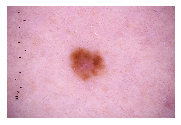

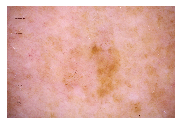

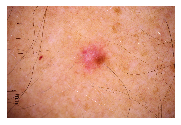

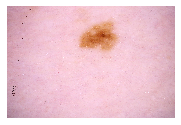

In [72]:
def imshow(image):
    """Display image"""
    img_name = image + '.jpg'
    img_path = data_train/img_name
    img = Image.open(img_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for image in tr_aug.image_name[:4]:
    imshow(image)

In [17]:
# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.X = df.iloc[:,0]
        self.y = df.iloc[:,1]
        self.transforms = transforms

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        img_name = self.X.iloc[i] + '.jpg'
        img_path = data_train/img_name
        img = Image.open(img_path)
        # pixels = asarray(img)

        # apply transformations
        data = self.transforms(img)

        return (data, self.y[i])

In [78]:
# transformations to apply to the "aug" and "no_aug" datasets

transformations_no_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomVerticalFlip(),
#     transforms.RandomPerspective(),
    transforms.Resize([1000,1000]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transformations_aug = transforms.Compose([
    transforms.Resize([1000,1000]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [41]:
# tensor to image
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

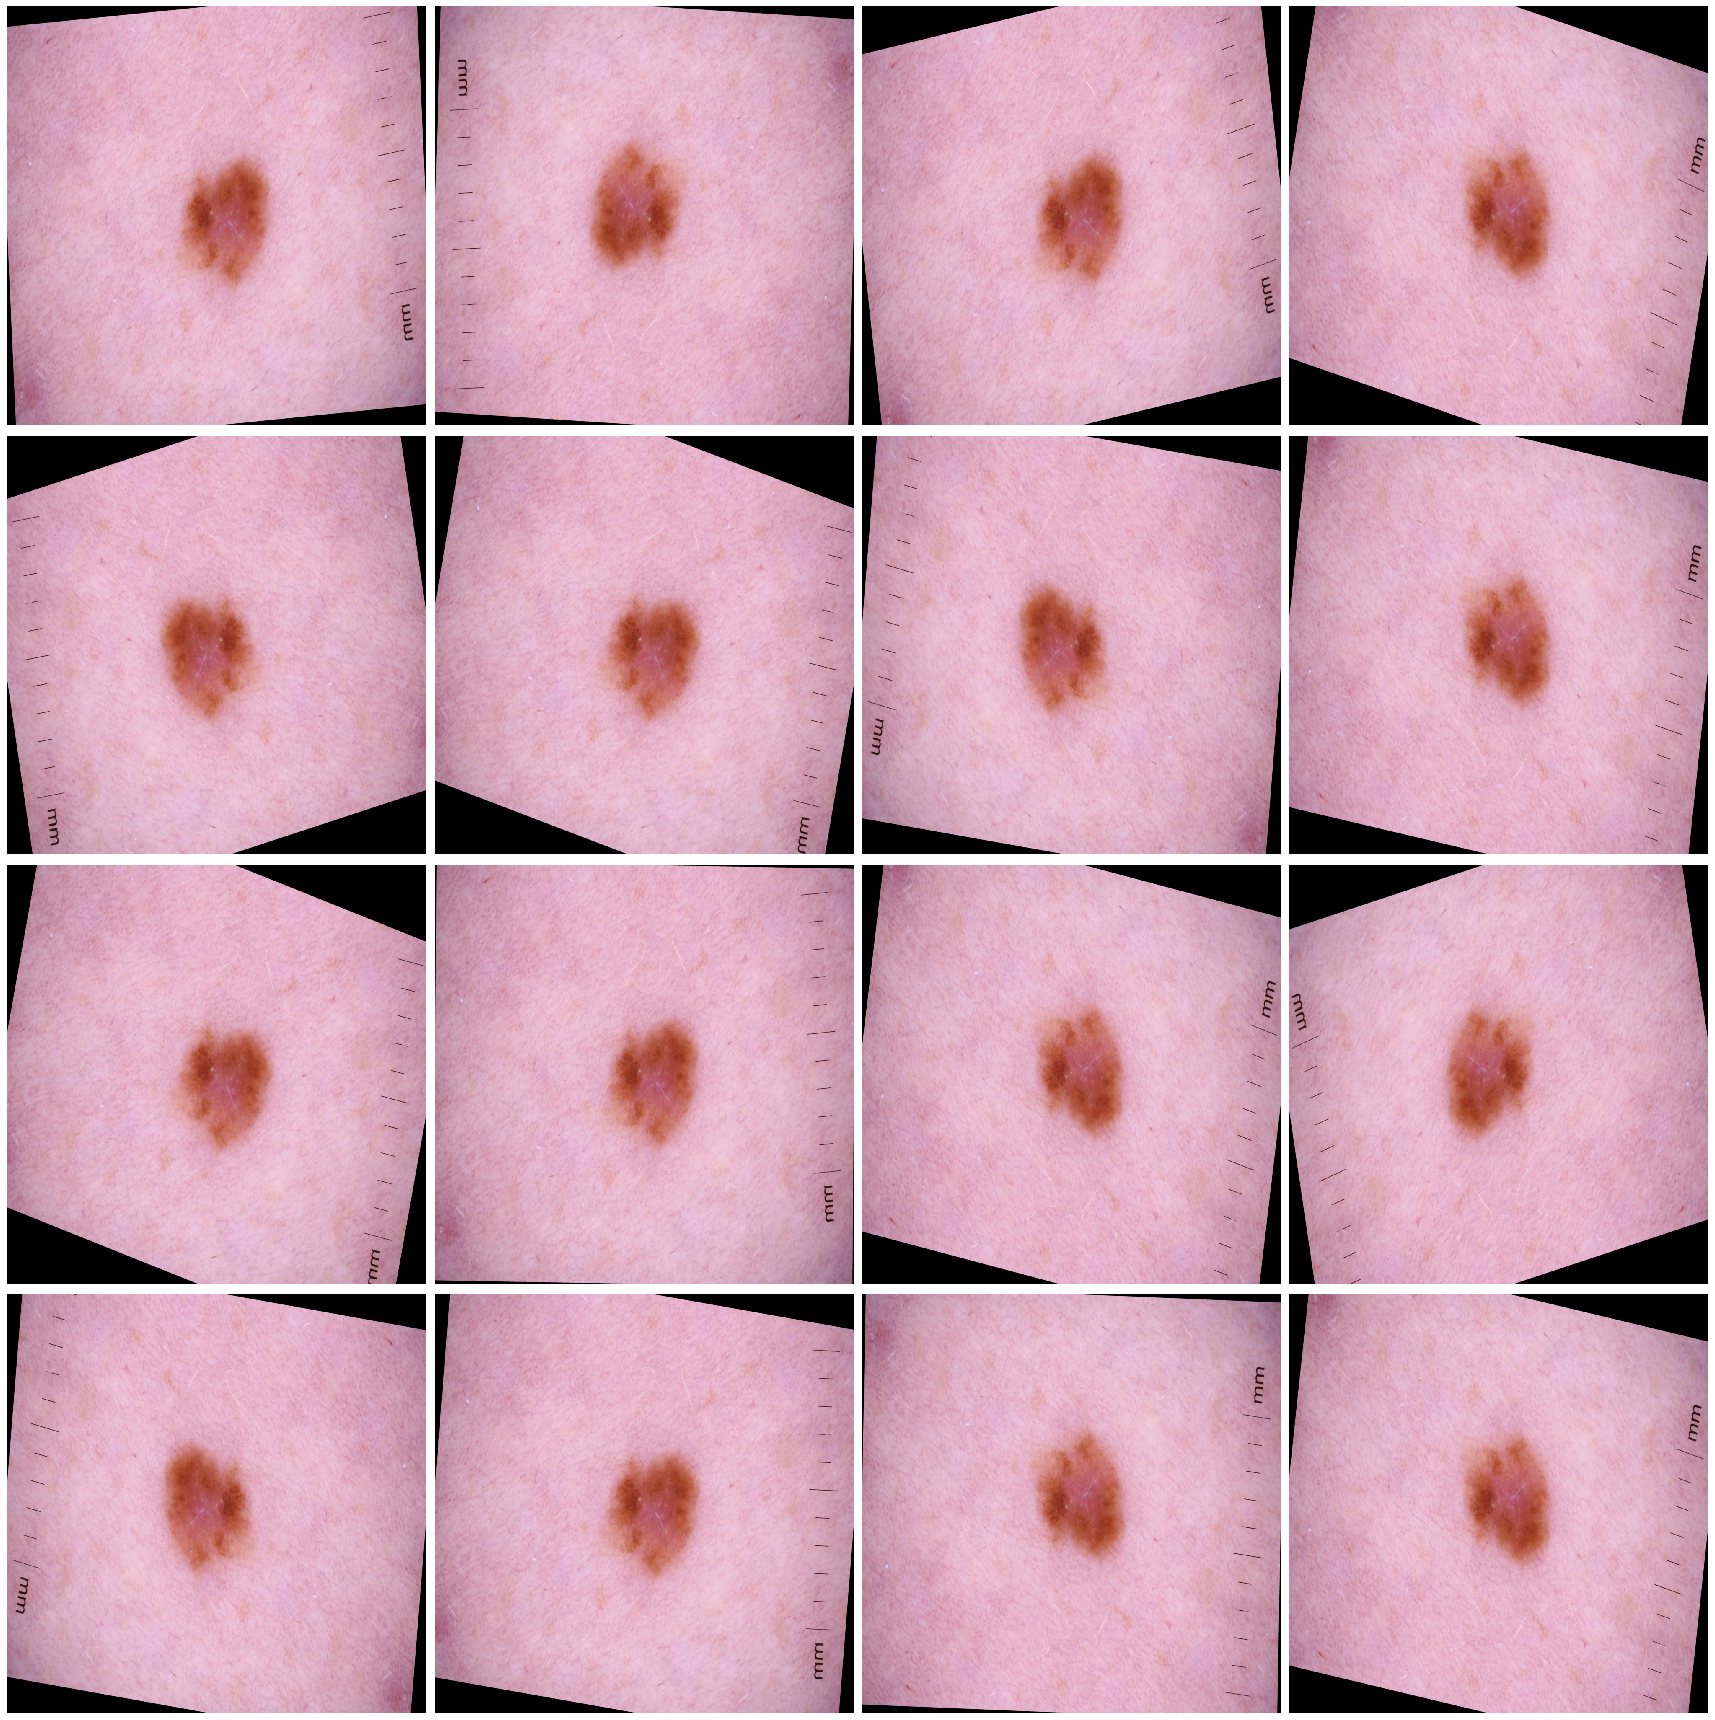

In [79]:
# example transformations
t = transformations_no_aug

image = tr_aug.image_name[:1].item()
img_name = image + '.jpg'
img_path = data_train/img_name
ex_img = Image.open(img_path)

plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [85]:
# loop through based on ratio (above) and create training dataset

# first aug_df doesn't need transformations
tr_no_aug_df = CustomDataset(tr, transforms=transformations_no_aug)
tr_aug_df = CustomDataset(tr_aug, transforms=transformations_no_aug)
tr_df = tr_no_aug_df + tr_aug_df

for i in range(int(ratio-1)):
    tr_aug_df_new = CustomDataset(tr_aug, transforms=transformations_aug)
    tr_df = tr_df + tr_aug_df_new

print(int(ratio))
print(len(tr_no_aug_df))
print(len(tr_aug_df))
print(len(tr_df))

# test set
te_df = CustomDataset(te, transforms=transformations_no_aug)

5
99
18
189


In [86]:
# torch dataloaders
train_loader = torch.utils.data.DataLoader(tr_df, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(te_df, batch_size=50, shuffle=True)